## Exploring experiments

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

from os import path
import logging
import dill
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from trojan_defender import (experiment, set_root_folder,
                             datasets, set_db_conf, plot,
                             get_db_conf)
from trojan_defender.detect import saliency_ as saliency
from trojan_defender import datasets
from pymongo import MongoClient

/home/Edu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/Edu/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# config logging
logging.basicConfig(level=logging.ERROR)

# matplotlib size
plt.rcParams['figure.figsize'] = (10, 10)

# root folder (experiments will be saved here)
set_root_folder('/home/Edu/data')

dump_folder = '/home/Edu/saliency'

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

In [21]:
clean = datasets.mnist()

def detect(directory):
    model, dataset, metadata = experiment.load(directory)

    try:
        res = saliency.detect(model, clean, random_trials=100)
        sms_model, outs, recovered, sample, stats, mask_prop = res
    except ValueError as e:
        print('error', e)
    else:
        print(stats)
    
    return res

In [26]:
def detection_round(model, dump=False):
    directory = model['directory']
    metrics = model['metrics']
    acc = metrics['accuracy_score']
    success = metrics.get('patch_success_rate') if metrics.get('patch_success_rate') else 0.0
    print(directory)
    print('{:.2f}\t{:.2f}'.format(acc, success))
    sms_model, outs, recovered, sample, res, mask_prop = detect(directory)
    print('\n\n')
    
    with open(path.join(dump_folder, directory+'.pickle'), 'wb') as f:
        res = sms_model, outs, recovered, sample, res, mask_prop
        dill.dump(res, f)

    return acc, success, res

In [18]:
def get_dump(directory):
    with open(path.join(dump_folder, directory+'.pickle'), 'rb') as f:
        res = dill.load(f)

    return res

In [6]:
conf = get_db_conf()
client = MongoClient(conf['uri'])
con = client[conf['db']][conf['collection']]

In [27]:
# noisy models
noisy = con.find({'dataset.name': 'MNIST',
                  'group_name': 'big_mnist_exp_12pm_2',
                  'dataset.dynamic_mask': True})

# baseline
baseline = con.find({'dataset.name': 'MNIST',
                     'group_name': 'big_mnist_exp_12pm_2',
                     'metrics.patch_success_rate': {"$exists": False}})

# attacks
# 'metrics.patch_success_rate': {"$lt": 0.05},
attacked = con.find({'dataset.name': 'MNIST',
                     'group_name': 'big_mnist_exp_12pm_2',
                     'dataset.dynamic_mask': False})

In [28]:
res_baseline = [detection_round(model) for model in baseline]

27-Apr-2018@16-26-51
0.99	0.00
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]





In [29]:
res_noisy = [detection_round(model) for model in noisy]

27-Apr-2018@16-27-46
0.99	0.00
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]



27-Apr-2018@16-28-43
0.99	0.00
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]



27-Apr-2018@16-29-40
0.99	0.00
[(None, None), (7, 0.01), (None, None), (None, None), (9, 0.36), (None, None), (None, None), (None, None), (None, None), (None, None)]



27-Apr-2018@16-30-36
0.99	0.00
[(None, None), (None, None), (None, None), (2, 0.03), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]



27-Apr-2018@16-31-33
0.99	0.00
[(None, None), (None, None), (None, None), (5, 0.54), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]



27-Apr-2018@16-32-31
0.99	0.00
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, 

[(None, None), (0, 0.94), (0, 0.46), (0, 0.77), (0, 1.0), (0, 1.0), (0, 0.71), (0, 0.7), (0, 0.97), (0, 0.87)]



27-Apr-2018@18-28-09
0.98	0.02
[(None, None), (0, 0.94), (0, 0.95), (0, 0.86), (0, 0.85), (0, 0.96), (0, 0.68), (0, 0.99), (0, 0.98), (0, 0.88)]



27-Apr-2018@18-29-22
0.98	0.02
[(None, None), (0, 0.99), (0, 1.0), (0, 1.0), (0, 0.99), (0, 0.98), (0, 0.98), (0, 0.97), (0, 1.0), (0, 1.0)]



27-Apr-2018@18-30-34
0.98	0.02
[(None, None), (0, 0.8), (0, 1.0), (0, 1.0), (0, 0.96), (0, 0.88), (0, 0.96), (0, 0.98), (0, 0.97), (0, 1.0)]



27-Apr-2018@18-31-47
0.98	0.02
[(None, None), (0, 0.99), (0, 1.0), (0, 0.95), (0, 1.0), (0, 1.0), (0, 1.0), (0, 0.99), (0, 0.97), (0, 1.0)]



27-Apr-2018@18-40-09
0.98	0.02
[(None, None), (0, 1.0), (0, 1.0), (0, 1.0), (0, 0.99), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0)]



27-Apr-2018@18-41-23
0.98	0.02
[(None, None), (0, 0.99), (0, 0.99), (0, 0.8), (0, 1.0), (0, 0.99), (0, 0.99), (0, 1.0), (0, 0.79), (0, 1.0)]



27-Apr-2018@18-42-37
0.

In [9]:
res_attacked = [detection_round(model) for model in attacked]

27-Apr-2018@16-33-30
0.99	0.62
(0.823, 0.08585452812752513) 0.9



27-Apr-2018@16-34-29
0.99	0.69
(0.806, 0.050635955604688664) 0.8



27-Apr-2018@16-35-35
0.98	0.77
(0.8540000000000002, 0.06988562083862461) 0.9



27-Apr-2018@16-36-34
0.98	1.00
(0.8960000000000004, 0.019595917942265416) 0.9



27-Apr-2018@16-37-41
0.98	1.00
(0.8990000000000004, 0.009949874371066198) 0.9



27-Apr-2018@16-38-40
0.98	1.00
(0.8980000000000004, 0.013999999999999995) 0.9





## Plots

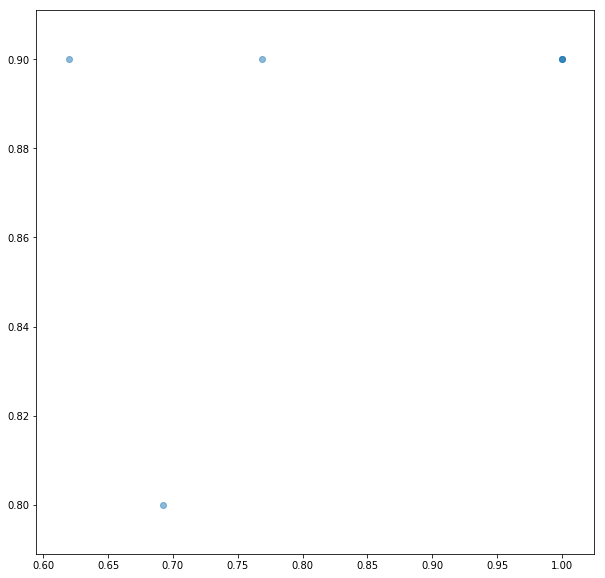

In [10]:
success = [r[1] for r in res]
mode_changes = [r[3] for r in res]

plt.scatter(success, mode_changes, alpha=0.5)